In [1]:
import copy
import h5py
import numpy as np
import os
import pandas as pd
import sys
import verdict

In [2]:
import analysis_config

In [3]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.cm as cm
import matplotlib.colors as plt_colors
import palettable

In [4]:
import linefinder.analyze_data.worldlines as a_worldlines
import linefinder.analyze_data.plot_worldlines as p_worldlines
import linefinder.utils.presentation_constants as p_constants

In [5]:
import galaxy_dive.analyze_data.halo_data as halo_data
import galaxy_dive.analyze_data.particle_data as particle_data
import galaxy_dive.plot_data.generic_plotter as generic_plotter
import galaxy_dive.plot_data.plotting as plotting
import galaxy_dive.utils.data_operations as data_operations
import galaxy_dive.utils.astro as astro_tools

In [6]:
import linefinder.utils.file_management as file_management_old
import linefinder.utils.file_management_new as file_management
import linefinder.config as config

# Load Data

### Parameters

In [7]:
# Sim params
default_sim = 'm12i'
default_snum = 600
resolution = 7100
physics = 'metal_diffusion'
subsubdir = None

In [8]:
# Halo file params
mt_kwargs = {
    'tag': 'smooth',
}

In [9]:
# Data selection params
t_window = 1. # In Gyr
galdef = ''
galaxy_cut = 0.1
length_scale = 'Rvir'

In [10]:
store_child_ids = False

### Get Data Structures

In [11]:
if len( sys.argv ) == 2:
    sim_name = sys.argv[1]
else:
    sim_name = default_sim

In [12]:
# Automatically set or retrieve args
if len( sys.argv ) == 3:
    try:
        snum = int( sys.argv[2] )
    except ValueError:
        snum = default_snum
else:
    snum = default_snum

In [13]:
sim_kwargs = dict(
    sim_name = sim_name,
    resolution = resolution,
    physics = physics,
    subsubdir = subsubdir,
)

In [14]:
fm = file_management.FileManager( 'hot_accretion' )
fm_old = file_management_old.FileManager( 'hot_accretion' )

In [17]:
ind = 600 - snum

In [18]:
g_data = particle_data.ParticleData(
    sdir = fm.get_sim_dir( **sim_kwargs ),
    snum = snum,
    ptype = config.PTYPE_GAS,
    halo_data_dir = fm.get_halo_dir( **sim_kwargs, halo_subdir='' ),
    main_halo_id = config.MAIN_MT_HALO_ID[sim_name],
    load_additional_ids = store_child_ids,
)

In [19]:
s_data = particle_data.ParticleData(
    sdir = fm.get_sim_dir( **sim_kwargs ),
    snum = snum,
    ptype = config.PTYPE_STAR,
    halo_data_dir = fm.get_halo_dir( **sim_kwargs, halo_subdir='' ),
    main_halo_id = config.MAIN_MT_HALO_ID[sim_name],
    load_additional_ids = store_child_ids,
)

In [21]:
# Load a time data array
time = astro_tools.age_of_universe(
    g_data.halo_data.get_mt_data( 'redshift', ),
    h = g_data.data_attrs['hubble'],
    omega_matter = g_data.data_attrs['omega_matter'],
)

In [22]:
# Find the time
prev_time_inds = np.arange(time.size)[np.isclose( time[ind] - t_window, time, atol=0.012 )]
assert prev_time_inds.size == 1
prev_time_ind = prev_time_inds[0]
snum_prior = 600 - prev_time_ind

In [23]:
g_data_prior = particle_data.ParticleData(
    sdir = fm.get_sim_dir( **sim_kwargs ),
    snum = snum_prior,
    ptype = config.PTYPE_GAS,
    halo_data_dir = fm.get_halo_dir( **sim_kwargs, halo_subdir='' ),
    main_halo_id = config.MAIN_MT_HALO_ID[sim_name],
    load_additional_ids = store_child_ids,
)

# Select Data

### Particles in the Galaxy Later

In [24]:
# Find characteristic length scale of the galaxy
len_scale = g_data.halo_data.get_mt_data(
    length_scale,
    snums=[snum,],
    mt_halo_id=g_data.main_halo_id
)
r_gal = galaxy_cut * len_scale

In [25]:
# Find gas particles in the main galaxy
is_in_gal_gas = (
    ( g_data.get_data( 'R' ) < r_gal ) &
    ( g_data.get_data( 'Den' ) > config.GALAXY_DENSITY_CUT )
)

In [26]:
# Find star particles in the main galaxy
is_in_gal_star = s_data.get_data( 'R' ) < r_gal

In [27]:
# Retrieve the relevant IDs
ids_gal = np.concatenate(
    (
        g_data.get_data( 'ID' )[is_in_gal_gas],
        s_data.get_data( 'ID' )[is_in_gal_star]
    )
)

In [28]:
if store_child_ids:
    child_ids_gal = np.concatenate(
        (
            g_data.get_data( 'ChildID' )[is_in_gal_gas],
            s_data.get_data( 'ChildID' )[is_in_gal_star]
        )
    )

### Particles in the CGM Earlier

In [29]:
# Find the CGM inner edge
len_scale_prior = g_data_prior.halo_data.get_mt_data(
    config.LENGTH_SCALE,
    snums=[snum_prior,],
    mt_halo_id=g_data.main_halo_id
)
cgm_inner_scale = 1.2 * config.GALAXY_CUT * len_scale_prior
cgm_inner_rvir = config.INNER_CGM_BOUNDARY * g_data_prior.r_vir
cgm_inner = max( cgm_inner_scale, cgm_inner_rvir )

In [30]:
is_in_CGM = g_data_prior.get_data( 'R' ) > cgm_inner

In [31]:
ids_cgm = g_data_prior.get_data( 'ID' )[is_in_CGM]

In [32]:
if store_child_ids:
    child_ids_cgm = g_data_prior.get_data( 'ChildID' )[is_in_CGM]

### Particles that Accreted

In [33]:
ids_accreted_alt = np.intersect1d( ids_gal, ids_cgm )

In [34]:
if store_child_ids:
    ids_str_gal = [ '{}_{}'.format( ids_gal[i], child_ids_gal[i] ) for i in range( ids_gal.size ) ]
    ids_str_cgm = [ '{}_{}'.format( ids_cgm[i], child_ids_cgm[i] ) for i in range( ids_cgm.size ) ]
    ids_str_accreted = np.intersect1d( ids_str_gal, ids_str_cgm )
    ids_accreted, child_ids_accreted = np.array( [ _.split( '_' ) for _ in ids_str_accreted ] ).astype( int ).transpose()
else:
    ids_accreted = ids_accreted_alt

In [35]:
if store_child_ids:
    extra_ids = np.array( list( set( ids_accreted_alt ) - set( ids_accreted ) ) )

# Plot Selected Data

## After

### Get Spatial Data

In [36]:
# Format Gas Data
data = {}
for key in [ 'ID', 'Rx', 'Ry', 'Rz', 'Den' ]:
    data[key] = g_data.get_data( key )
df = pd.DataFrame( data )

# Get rid of duplicates
df = df.drop_duplicates( 'ID', keep=False )

df = df.set_index( 'ID' )

In [37]:
is_acc = df.index.isin( ids_accreted )
df_acc = df[is_acc]

In [38]:
if store_child_ids:
    is_extra = df.index.isin( extra_ids )
    df_extra = df[is_extra]

In [39]:
# Format Star Data
data = {}
for key in [ 'ID', 'Rx', 'Ry', 'Rz' ]:
    data[key] = s_data.get_data( key )
df = pd.DataFrame( data )

# Get rid of duplicates
df = df.drop_duplicates( 'ID', keep=False )

df = df.set_index( 'ID' )

In [40]:
is_acc = df.index.isin( ids_accreted )
df_acc_star = df[is_acc]

In [41]:
if store_child_ids:
    is_extra = df.index.isin( extra_ids )
    df_extra_star = df[is_extra]

### Plot After

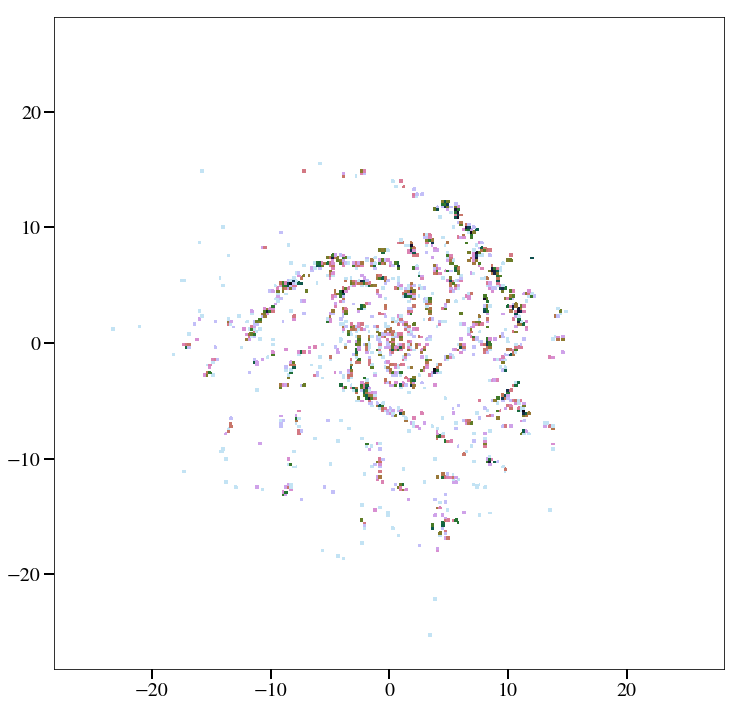

In [42]:
fig = plt.figure( figsize=(12, 12), facecolor='white' )
ax = plt.gca()

ax.hist2d(
    df_acc['Rx'],
    df_acc['Ry'],
    bins = 256,
    range = 1.5 * r_gal * np.array( [ [ -1., 1. ], [ -1., 1. ], ] ),
    cmap = palettable.cubehelix.classic_16_r.get_mpl_colormap(),
    norm = plt_colors.LogNorm(),
)

fig

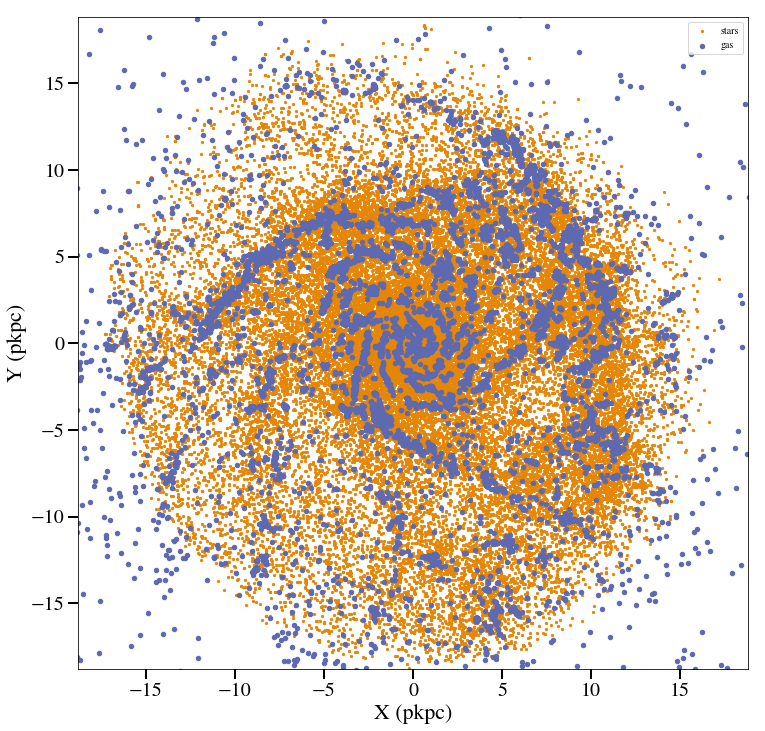

In [43]:
fig = plt.figure( figsize=(12, 12), facecolor='white' )
ax = plt.gca()

ax.scatter(
    df_acc_star['Rx'],
    df_acc_star['Ry'],
    color = palettable.cartocolors.qualitative.Vivid_2.mpl_colors[0],
    s = 5,
    label = 'stars',
)

ax.scatter(
    df_acc['Rx'],
    df_acc['Ry'],
    color = palettable.cartocolors.qualitative.Vivid_2.mpl_colors[1],
    s = 20,
    label = 'gas',
)


ax.set_xlabel( 'X (pkpc)', fontsize=22, )
ax.set_ylabel( 'Y (pkpc)', fontsize=22, )

ax.set_xlim( -1. * r_gal, 1. * r_gal )
ax.set_ylim( -1. * r_gal, 1. * r_gal )

ax.legend()

fig

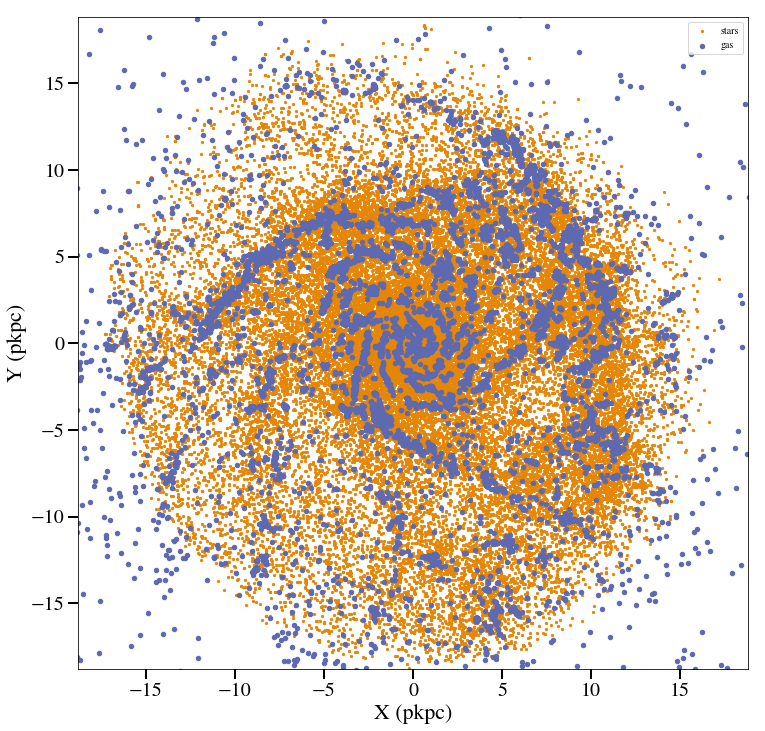

In [44]:
if store_child_ids:
    fig = plt.figure( figsize=(12, 12), facecolor='white' )
    ax = plt.gca()

    ax.hist2d(
        df_extra['Rx'],
        df_extra['Ry'],
        bins = 128,
        range = 1.5 * r_gal * np.array( [ [ -1., 1. ], [ -1., 1. ], ] ),
        cmap = palettable.cubehelix.classic_16_r.get_mpl_colormap(),
        norm = plt_colors.LogNorm(),
    )

fig

In [45]:
if store_child_ids:
    fig = plt.figure( figsize=(12, 12), facecolor='white' )
    ax = plt.gca()

    ax.scatter(
        df_extra['Rx'],
        df_extra['Ry'],
        color = palettable.cartocolors.qualitative.Vivid_2.mpl_colors[1],
        s = 25,
        label = 'gas',
    )
    
    ax.scatter(
        df_extra_star['Rx'],
        df_extra_star['Ry'],
        color = palettable.cartocolors.qualitative.Vivid_2.mpl_colors[0],
        s = 5,
        label = 'stars',
    )


    ax.set_xlabel( 'X (pkpc)', fontsize=22, )
    ax.set_ylabel( 'Y (pkpc)', fontsize=22, )

    ax.set_xlim( -1. * r_gal, 1. * r_gal )
    ax.set_ylim( -1. * r_gal, 1. * r_gal )

    ax.legend()

    fig

## Check Results of Splitting

In [46]:
if store_child_ids:

    g_dups = g_data.find_duplicate_ids()

    s_dups = s_data.find_duplicate_ids()

    gs_dups = np.intersect1d( g_data.get_data( 'ID' ), s_data.get_data( 'ID' ) )

    all_dups = np.union1d( np.union1d( g_dups, s_dups, ), gs_dups )
    
    g_prior_dups = g_data_prior.find_duplicate_ids()

In [47]:
if store_child_ids:

    print( 'Percent of galaxy ids with duplicates = {:.2g}%'.format( np.intersect1d( all_dups, ids_gal ).size / ids_gal.size * 100 ) )

    print( 'Percent of CGM ids with duplicates = {:.2g}%'.format( np.intersect1d( ids_cgm, g_prior_dups ).size / ids_cgm.size * 100 ) )

    print( 'Percent of galaxy ids targeted = {:.2g}%'.format( ids_accreted.size / ids_gal.size * 100 ) )

    print( 'Percent of CGM ids targeted = {:.2g}%'.format( ids_accreted.size / ids_cgm.size * 100 ) )

    n_dups = np.intersect1d( ids_accreted_alt, all_dups ).size

    cgm_before_dup_after = np.intersect1d( ids_cgm, np.intersect1d( all_dups, ids_gal ) )

    dup_before_gal_after = np.intersect1d( ids_gal, np.intersect1d( g_prior_dups, ids_cgm ) )

    dup_before_dup_after = np.intersect1d( np.intersect1d( all_dups, ids_gal ), np.intersect1d( g_prior_dups, ids_cgm )  )

    all_relevant_dup_ids = np.union1d( np.union1d( cgm_before_dup_after, dup_before_gal_after ), dup_before_dup_after )
    
    print( 'Percent of duplicates CGM before, duplicate after = {:.2g}%'.format( cgm_before_dup_after.size / n_dups * 100 ) )

    print( 'Percent of duplicates duplicate before, galaxy after = {:.2g}%'.format( dup_before_gal_after.size / n_dups * 100 ) )

    print( 'Accounted for IDs = {}, number of duplicate IDs = {}'.format( all_relevant_dup_ids.size, np.intersect1d( ids_accreted_alt, all_dups ).size ) )

## Before

### Get Spatial Data

In [48]:
# Format Data
data = {}
for key in [ 'ID', 'Rx', 'Ry', 'Rz' ]:
    data[key] = g_data_prior.get_data( key )
df_prior = pd.DataFrame( data )

# Get rid of duplicates
df_prior = df_prior.drop_duplicates( 'ID', keep=False )

df_prior = df_prior.set_index( 'ID' )

In [49]:
df_acc_prior = df_prior[df_prior.index.isin( ids_accreted )]

In [50]:
if store_child_ids:
    df_extra_prior = df_prior[df_prior.index.isin( extra_ids )]

### Plot Before

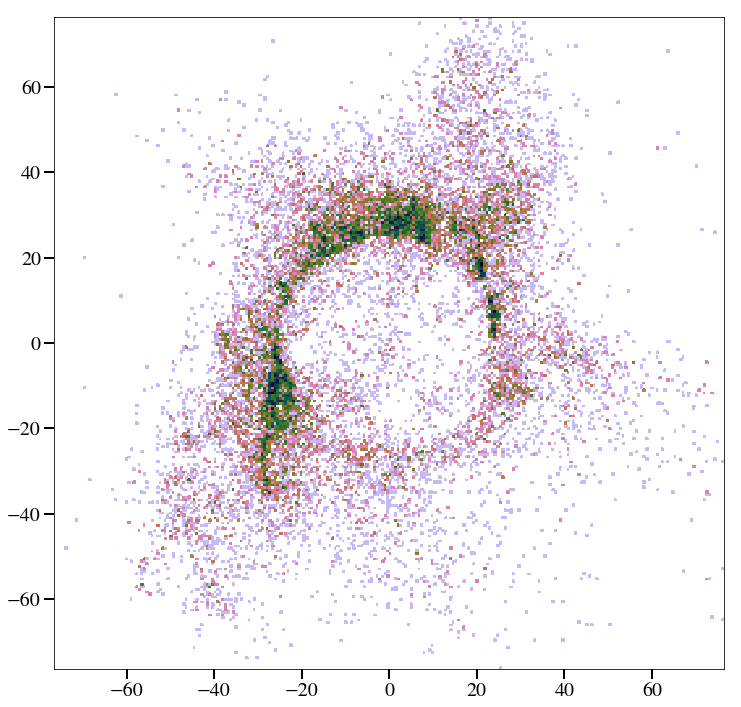

In [51]:
fig = plt.figure( figsize=(12, 12), facecolor='white' )
ax = plt.gca()

ax.hist2d(
    df_acc_prior['Rx'],
    df_acc_prior['Ry'],
    bins = 256,
    range = 0.3 * g_data_prior.r_vir * np.array( [ [ -1., 1. ], [ -1., 1. ], ] ),
    cmap = palettable.cubehelix.classic_16_r.get_mpl_colormap(),
    norm = plt_colors.LogNorm(),
)

fig

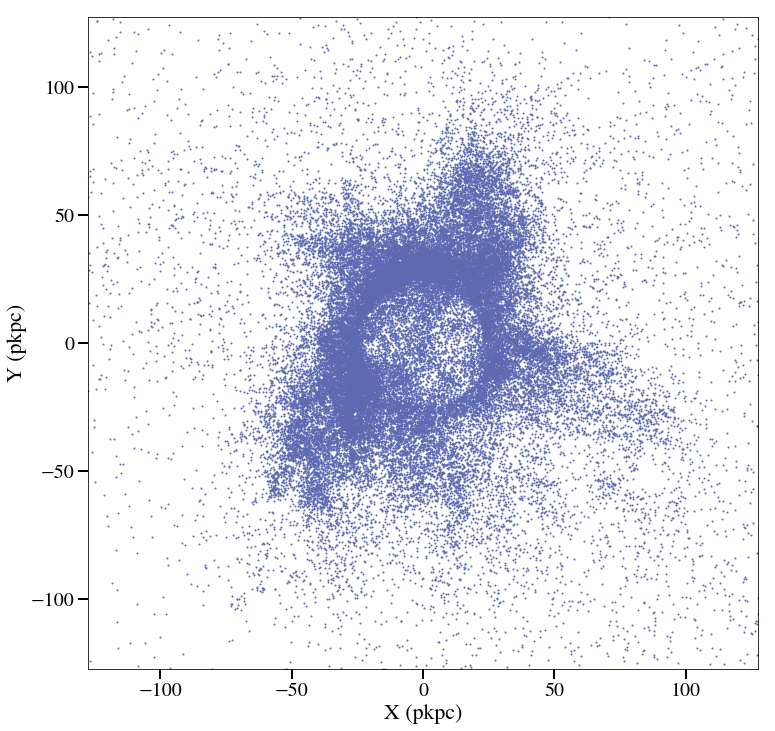

In [52]:
fig = plt.figure( figsize=(12, 12), facecolor='white' )
ax = plt.gca()

ax.scatter(
    df_acc_prior['Rx'],
    df_acc_prior['Ry'],
    color = palettable.cartocolors.qualitative.Vivid_2.mpl_colors[1],
    s = 1,
)

ax.set_xlabel( 'X (pkpc)', fontsize=22, )
ax.set_ylabel( 'Y (pkpc)', fontsize=22, )

ax.set_xlim( -0.5 * g_data_prior.r_vir, 0.5 * g_data_prior.r_vir )
ax.set_ylim( -0.5 * g_data_prior.r_vir, 0.5 * g_data_prior.r_vir )

fig

In [53]:
if store_child_ids:
    fig = plt.figure( figsize=(12, 12), facecolor='white' )
    ax = plt.gca()

    ax.scatter(
        df_extra_prior['Rx'],
        df_extra_prior['Ry'],
        color = palettable.cartocolors.qualitative.Vivid_2.mpl_colors[1],
        s = 1,
    )

    ax.set_xlabel( 'X (pkpc)', fontsize=22, )
    ax.set_ylabel( 'Y (pkpc)', fontsize=22, )

    ax.set_xlim( -0.5 * g_data_prior.r_vir, 0.5 * g_data_prior.r_vir )
    ax.set_ylim( -0.5 * g_data_prior.r_vir, 0.5 * g_data_prior.r_vir )

    fig

# Save Data

## ID Data

In [54]:
child_ids_str = {
    True: '_split',
    False: '',
}[store_child_ids]

In [55]:
physics_str = {
    'metal_diffusion': '_md',
    'core': '',
    'cr_heating_fix': '_cr',
}[physics]

In [58]:
file_name = 'ids_full_{}{}_hothaloacc{}.hdf5'.format( sim_name, physics_str, child_ids_str )
data_dir = fm.get_linefinder_dir( **sim_kwargs )
os.makedirs( data_dir, exist_ok=True )
file_path = os.path.join( data_dir, file_name )
g = h5py.File( file_path, 'w' )

In [59]:
g.create_dataset( 'target_ids', data=ids_accreted )

<HDF5 dataset "target_ids": shape (69897,), type "<i8">

In [60]:
if store_child_ids:
    g.create_dataset( 'target_child_ids', data=child_ids_accreted )

In [61]:
g.close()

In [62]:
print( 'Saved at {}'.format( file_path ) )

Saved at /scratch/03057/zhafen/linefinder_data/metal_diffusion/m12i_res7100/data/ids_full_m12i_md_hothaloacc.hdf5


## Summary Statistics Data

In [63]:
tot_momentum_fp = os.path.join( data_dir, 'tot_momentums.hdf5'.format( snum ) )

In [64]:
try:
    tot_momentums = verdict.Dict.from_hdf5( tot_momentum_fp )
except IOError:
    tot_momentums = verdict.Dict( {} )

In [65]:
sim_str = '{}{}'.format( sim_name, physics_str )
if sim_str not in tot_momentums:
    tot_momentums[sim_str] = {}

In [66]:
tot_momentums[sim_str]['snum{:03d}'.format( snum )] = g_data.total_ang_momentum

In [67]:
tot_momentums[sim_str]['snum{:03d}'.format( snum_prior )] = g_data_prior.total_ang_momentum

In [68]:
tot_momentums.to_hdf5( tot_momentum_fp )

The angles are consistent both across time and stars/gas:

In [69]:
print(
        'Change between gas angular momentum now and 1 Gyr ago: {:.2g} degrees'.format(
        np.arccos(
            np.dot(
                g_data.total_ang_momentum / np.linalg.norm( g_data.total_ang_momentum ),
                g_data_prior.total_ang_momentum / np.linalg.norm( g_data_prior.total_ang_momentum ),
            )
        ) / np.pi * 180.
    )
)

Change between gas angular momentum now and 1 Gyr ago: 8.5 degrees


In [70]:
print(
        'Change between gas angular momentum now and stellar angular momentum now: {:.2g} degrees'.format(
        np.arccos(
            np.dot(
                g_data.total_ang_momentum / np.linalg.norm( g_data.total_ang_momentum ),
                s_data.total_ang_momentum / np.linalg.norm( s_data.total_ang_momentum ),
            )
        ) / np.pi * 180.
    )
)

Change between gas angular momentum now and stellar angular momentum now: 1.6 degrees
